In [18]:
import pandas as pd
import numpy as np
import re
import spacy

In [32]:
recipes = pd.read_csv('RAW_recipes.csv')

In [33]:
recipes.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [34]:
recipes.columns.values

array(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'nutrition', 'n_steps', 'steps', 'description', 'ingredients',
       'n_ingredients'], dtype=object)

In [35]:
recipes.shape
recipes.isnull().sum()

name                 1
id                   0
minutes              0
contributor_id       0
submitted            0
tags                 0
nutrition            0
n_steps              0
steps                0
description       4979
ingredients          0
n_ingredients        0
dtype: int64

In [36]:
recipes.shape

(231637, 12)

In [37]:
# Dropping the description, contributor_id, submitted cols 
recipes = recipes.drop('description', axis=1)
recipes = recipes.drop('contributor_id', axis=1)
recipes = recipes.drop('submitted', axis=1)
recipes.columns.values


array(['name', 'id', 'minutes', 'tags', 'nutrition', 'n_steps', 'steps',
       'ingredients', 'n_ingredients'], dtype=object)

In [38]:
recipes['ingredients'].head(10)

0    ['winter squash', 'mexican seasoning', 'mixed ...
1    ['prepared pizza crust', 'sausage patty', 'egg...
2    ['ground beef', 'yellow onions', 'diced tomato...
3    ['spreadable cheese with garlic and herbs', 'n...
4    ['tomato juice', 'apple cider vinegar', 'sugar...
5    ['milk', 'vanilla ice cream', 'frozen apple ju...
6    ['fennel seeds', 'green olives', 'ripe olives'...
7    ['pork spareribs', 'soy sauce', 'fresh garlic'...
8    ['chocolate sandwich style cookies', 'chocolat...
9    ['sugar', 'unsalted butter', 'bananas', 'eggs'...
Name: ingredients, dtype: object

In [39]:
recipes['steps'][0]

"['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourths', 'remove seeds', 'for spicy squash , drizzle olive oil or melted butter over each cut squash piece', 'season with mexican seasoning mix ii', 'for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece', 'season with sweet mexican spice mix', 'bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin', 'be careful not to burn the squash especially if you opt to use sugar or butter', 'if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking', 'if desired , season with salt']"

In [40]:
recipes.shape

(231637, 9)

In [41]:
# Recipe instructions with less than 20 characters are not good recipes
empty_instr_ind = [index for i, index in zip(recipes['steps'], recipes.index) if len(i) < 20]
recipes = recipes.drop(index = empty_instr_ind).reset_index(drop=True)
recipes.shape

(231575, 9)

In [42]:
[i for i in recipes['n_steps'] if i == 0]

[]

### Pre processing data

In [43]:
import ast
print(recipes['ingredients'].size)
tmp = [ast.literal_eval(i) for i in recipes['ingredients']]
# ingredients = [ast.literal_eval(recipes['ingredients'][i] for i in recipes['ingredients'])]
# ingredients 

231575


In [44]:
recipes = recipes.drop('ingredients', axis=1)
recipes['ingredients'] = tmp

In [45]:
recipes['ingredients'][0]

['winter squash',
 'mexican seasoning',
 'mixed spice',
 'honey',
 'butter',
 'olive oil',
 'salt']

In [46]:
# Extracting ingredients from their lists and formatting as single strings
recipes['ingredient_text'] = ['; '.join(ingredients) for ingredients in recipes['ingredients']]
recipes['ingredient_text'].head()


0    winter squash; mexican seasoning; mixed spice;...
1    prepared pizza crust; sausage patty; eggs; mil...
2    ground beef; yellow onions; diced tomatoes; to...
3    spreadable cheese with garlic and herbs; new p...
4    tomato juice; apple cider vinegar; sugar; salt...
Name: ingredient_text, dtype: object

In [47]:
all_text = recipes['name'] + ' ' + recipes['ingredient_text'] + ' ' + recipes['steps']
all_text[0]

"arriba   baked winter squash mexican style winter squash; mexican seasoning; mixed spice; honey; butter; olive oil; salt ['make a choice and proceed with recipe', 'depending on size of squash , cut into half or fourths', 'remove seeds', 'for spicy squash , drizzle olive oil or melted butter over each cut squash piece', 'season with mexican seasoning mix ii', 'for sweet squash , drizzle melted honey , butter , grated piloncillo over each cut squash piece', 'season with sweet mexican spice mix', 'bake at 350 degrees , again depending on size , for 40 minutes up to an hour , until a fork can easily pierce the skin', 'be careful not to burn the squash especially if you opt to use sugar or butter', 'if you feel more comfortable , cover the squash with aluminum foil the first half hour , give or take , of baking', 'if desired , season with salt']"

In [48]:
# Clean_text Function
import string
import re

def clean_text(documents):
    cleaned_text = []
    for doc in documents:
        try:
            doc = doc.translate(str.maketrans('', '', string.punctuation)) # Remove Punctuation
            doc = re.sub(r'\d+', '', doc) # Remove Digits
            doc = doc.replace('\n',' ') # Remove New Lines
            doc = doc.strip() # Remove Leading White Space
            doc = re.sub(' +', ' ', doc) # Remove multiple white spaces
            cleaned_text.append(doc)
        except Exception as e:
            print(doc)
    return cleaned_text

# Cleaning Text
cleaned_text = clean_text(all_text)

nan


In [49]:
cleaned_text[1]

'a bit different breakfast pizza prepared pizza crust sausage patty eggs milk salt and pepper cheese preheat oven to degrees f press dough into the bottom and sides of a inch pizza pan bake for minutes until set but not browned cut sausage into small pieces whisk eggs and milk in a bowl until frothy spoon sausage over baked crust and sprinkle with cheese pour egg mixture slowly over sausage and cheese s p to taste bake minutes or until eggs are set and crust is brown'

### Tokenizing Using Spacy

For this tokenization, we will lemmatize the words. This is will help create a denser word embeddings. However, no POS tagging, know entities, or noun_phrases will be parsed and added.

In [50]:
# Testing Strategies and Code
nlp = spacy.load('en_core_web_sm')

' '.join([token.lemma_ for token in nlp(cleaned_text[2]) if not token.is_stop])

'kitchen chili ground beef yellow onion dice tomato tomato paste tomato soup rotel tomatoe kidney bean water chili powder ground cumin salt lettuce cheddar cheese brown ground beef large pot add chop onion ground beef brown sautee wilt add ingredient add kidney bean like bean chili cook slow cooker high hour hour low serve cold clean lettuce shred cheese'

In [51]:
# Tokenizing Function that lemmatizes words and removes Stop Words
def text_tokenizer(documents):
    tokenized_documents = []
    for doc in documents:
        tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
        tokenized_documents.append(tok_doc)
    return tokenized_documents

In [52]:
# Tokenizing Function to run in parallel
def text_tokenizer_mp(doc):
    tok_doc = ' '.join([token.lemma_ for token in nlp(doc) if not token.is_stop])
    return tok_doc

In [23]:
import multiprocessing as mp
print("Number of processors: ", mp.cpu_count())

Number of processors:  20


In [24]:
# Parallelzing tokenizing process
pool = mp.Pool(mp.cpu_count())
tokenized_text = pool.map(text_tokenizer_mp, [doc for doc in cleaned_text])

KeyboardInterrupt: 

In [ ]:
# Save the tokenized_text variable as a csv in order to return to it;
# Do not attempt to run the parser above, it will simply take too long
# Reload the csv from file insted
pd.Series(tokenized_text).to_csv('tokenized_text.csv')

NameError: name 'pd' is not defined

In [7]:
import pandas as pd
tokenized_text = pd.read_csv('tokenized_text.csv')

In [8]:
tokenized_text['tokenized']

0         arriba baked winter squash mexican style winte...
1         bit different breakfast pizza prepared pizza c...
2         kitchen chili ground beef yellow onion dice to...
3         alouette potatoe spreadable cheese garlic herb...
4         amish tomato ketchup can tomato juice apple ci...
                                ...                        
231569    zydeco soup celery onion green sweet pepper ga...
231570    zydeco spice mix paprika salt garlic powder on...
231571    zydeco ya ya devil egg hardcooke egg mayonnais...
231572    cookie design cookie stick butter eagle brand ...
231573    cookie design sugar shortbread cookies granula...
Name: tokenized, Length: 231574, dtype: object

### Creating Word Embeddings

- TF-IDF
- Pre-trained GloVe Word Embeddings
- GloVe Embeddings trained on the recipe corpora

In an attempt to create dense word embeddings, I could find no reliable examples to follow that integrate GloVe or Word2Vec with document topic modeling.

In [9]:
tokenized_text = tokenized_text['tokenized']

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase = True,
                            ngram_range = (1,1))

text_tfidf = vectorizer.fit_transform(tokenized_text)
tfidf_words = vectorizer.get_feature_names()
print(text_tfidf.shape)
print(len(tfidf_words))

(231574, 62557)
62557


c:\Users\mehta\OneDrive\Desktop\ec2\venv\Lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [11]:
text_tfidf.shape

(231574, 62557)

In [13]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components = 50,
          n_jobs = 20,
          max_iter = 100,
          verbose=1)
text_lda = lda.fit_transform(text_tfidf)
text_lda.shape

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100
iteration: 31 of max_iter: 100
iteration: 32 of max_iter: 100
iteration: 33 of 

(231574, 50)

In [14]:
text_lda

array([[0.0031696 , 0.0031696 , 0.0031696 , ..., 0.2162936 , 0.0031696 ,
        0.0031696 ],
       [0.00340117, 0.00340117, 0.00340117, ..., 0.00340117, 0.00340117,
        0.00340117],
       [0.00305654, 0.00305654, 0.00305654, ..., 0.00305654, 0.00305654,
        0.00305654],
       ...,
       [0.00343319, 0.00343319, 0.08793859, ..., 0.00343319, 0.00343319,
        0.00343319],
       [0.00239279, 0.00239279, 0.00239279, ..., 0.0302313 , 0.00239279,
        0.00239279],
       [0.00330374, 0.00330374, 0.00330374, ..., 0.00330374, 0.00330374,
        0.00330374]])

In [16]:
from sklearn.decomposition import NMF

nmf = NMF(alpha=0.0,
         init='nndsvdar',
         l1_ratio=0.0,
         max_iter = 100,
         n_components = 50,
         solver='cd',
         verbose=1)

text_nmf = nmf.fit_transform(text_tfidf)
text_nmf.shape

c:\Users\mehta\OneDrive\Desktop\ec2\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1477: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
  warnings.warn(


violation: 1.0
violation: 0.1907370371936334
violation: 0.14550655615809616
violation: 0.1041587175271174
violation: 0.07164113003721638
violation: 0.04978332592009089
violation: 0.035915184699211206
violation: 0.028381223805984672
violation: 0.024696726044272383
violation: 0.022473551906096356
violation: 0.02075767260538417
violation: 0.01963543192068558
violation: 0.018980930126074096
violation: 0.018286302828221482
violation: 0.017207355344769176
violation: 0.015815930929929185
violation: 0.014233664717906899
violation: 0.012760445304763945
violation: 0.01116886671644422
violation: 0.009668351955130392
violation: 0.00831609687799812
violation: 0.007121252083786175
violation: 0.006133083681674112
violation: 0.005437140889801001
violation: 0.004882387192651809
violation: 0.004426327619942509
violation: 0.004020961039583988
violation: 0.0036855239824811667
violation: 0.0034052779704346952
violation: 0.0031599364832513273
violation: 0.002953044586236959
violation: 0.0027684122482221074


c:\Users\mehta\OneDrive\Desktop\ec2\venv\Lib\site-packages\sklearn\decomposition\_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 100 reached. Increase it to improve convergence.
  warnings.warn(


(231574, 50)

In [53]:
# variable dependencies:
text_series = pd.Series(all_text)

def docs_by_tops(top_mat, topic_range = (0,0), doc_range = (0,2)):
    for i in range(topic_range[0], topic_range[1]):
        topic_scores = pd.Series(top_mat[:,i])
        doc_index = topic_scores.sort_values(ascending = False)[doc_range[0]:doc_range[1]].index
        for j, index in enumerate(doc_index, doc_range[0]):
            print('Topic #{}'.format(i),
                  '\nDocument #{}'.format(j),
                  '\nTopic Score: {}\n\n'.format(topic_scores[index]),
                  text_series[index], '\n\n')

In [54]:
docs_by_tops(text_lda,(0,3),(0,3))

Topic #0 
Document #0 
Topic Score: 0.37884968488341964

 farmhouse hearty mushroom  asparagus and bacon quiche bacon; refrigerated crescent dinner rolls; prepared mustard; butter; fresh asparagus; onion; fresh mushrooms; eggs; thyme; salt & pepper; garlic powder; parsley; mozzarella cheese ['fry bacon , drain , crumble', 'remove from pan , pour off grease', 'set aside', 'separate crescent rolls into triangles , place in ungreased 9-inch pie plate , press seams together over the bottom and up the sides to form the crust', 'spread with mustard', 'set aside', 'preheat oven to 375', 'in bacon pan , melt butter', 'saute asparagus , onions & mushrooms until tender-crisp', 'in a large bowl , combine custard ingredients', 'bake for 25-30 minutes', 'let stand 5 minutes before cutting', 'mmm-good !'] 


Topic #0 
Document #1 
Topic Score: 0.3420603263208174

 painkiller mocktail british virgin islands pineapple juice; cream of coconut; orange juice; fresh nutmeg ['in a cocktail shaker filled wi

C:\Users\mehta\AppData\Local\Temp\ipykernel_4032\1705474374.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  doc_index = topic_scores.sort_values(ascending = False)[doc_range[0]:doc_range[1]].index


In [55]:
docs_by_tops(text_nmf,(0,3),(0,3))

Topic #0 
Document #0 
Topic Score: 0.021304913070302575

 cilantro cream for fish tacos fresh cilantro; creme fraiche; fresh lemon juice ['puree cilantro , creme franche , and lemon juice in blender until smooth', 'season to taste with salt and pepper', 'refridgerate at least 30 minutes to allow flavors to blend'] 


Topic #0 
Document #1 
Topic Score: 0.0212792952559664

 onion compote spanish onion; honey; red wine vinegar; water; butter; salt & freshly ground black pepper ['in a saucepan over medium heat combine onions and honey', 'cook slowly until caramelized , about 45 minutes', 'add vinegar and stir', 'add water and reduce to low heat', 'cook uncovered until liquid has been absorbed', 'onions are done when they are tender , have melted together , and are moist but not wet', 'whisk in butter', 'season', 'let cool and store in a mason jar', 'when ready to use , reheat the compote over low heat and adjust seasoning', 'onion compote will keep refrigerated for at least a month', 'en

C:\Users\mehta\AppData\Local\Temp\ipykernel_4032\1705474374.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  doc_index = topic_scores.sort_values(ascending = False)[doc_range[0]:doc_range[1]].index


In [56]:
docs_by_tops(text_nmf,(1,2),(90000,90001))

Topic #1 
Document #90000 
Topic Score: 0.0009233528150811972

 brown rice  basil  and gruyere garden stuffing long grain brown rice; unsalted butter; onion; zucchini; carrots; celery; red bell pepper; fresh mushrooms; garlic; gruyere; fresh basil; salt; fresh ground pepper; turkey broth ['bring a big pot of lightly salted water to a boil over high heat', 'add in the brown rice', 'lower the heat to medium', 'boil , uncovered , for about 35 minutes or until the rice is barely tender', 'drain rice in a sieve and rinse under cold running water', 'transfer rice to a large mixing bowl', 'in a large non-stick skillet over medium heat , let the butter melt', 'add in the onion , zucchini , carrots , celery , red pepper , mushrooms , and garlic', 'cover and cook about 10-12 minutes until the onion is soft and translucent and veggies are barely tender', 'stir often', 'transfer the veggies into the mixing bowl with the rice', 'stir to mix', 'add in the cheese and basil', 'stir to mix', 'add in sa

C:\Users\mehta\AppData\Local\Temp\ipykernel_4032\1705474374.py:7: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  doc_index = topic_scores.sort_values(ascending = False)[doc_range[0]:doc_range[1]].index


Exploring topics by words

In [57]:
text_nmf.shape

(231574, 50)

In [58]:
text_tfidf.T.shape

(62557, 231574)

In [59]:
# Function for best topic words using cosine similarity
# Variable Dependency:
word_series = pd.Series(tfidf_words)

def words_by_tops(tfidf_mat, top_mat, topic_range=(0,0), n_words=10):
    topic_word_scores = tfidf_mat.T * top_mat
    for i in range(topic_range[0],topic_range[1]):
        word_scores = pd.Series(topic_word_scores[:,i])
        word_index = word_scores.sort_values(ascending = False)[:n_words].index
        print('\nTopic #{}'.format(i))
        for index in word_index:
            print(word_series[index],'\t\t', word_scores[index])

In [60]:
# Keywords using LDA
words_by_tops(text_tfidf, text_lda, (0,3), 10)


Topic #0
add 		 36.587751637112525
pepper 		 34.036876385617056
cheese 		 33.64426189901116
minute 		 32.27428589040912
sugar 		 32.11584998768342
chicken 		 31.535556978568717
salt 		 31.33496721217524
butter 		 31.08200870862511
onion 		 30.17557298599951
oil 		 27.986957656697864

Topic #1
fish 		 665.3411401867254
salmon 		 544.2762754948862
fillet 		 478.73675175321347
lemon 		 255.83995628024826
pepper 		 249.31210630801218
oil 		 203.4603185411938
salt 		 190.1763123358105
minute 		 187.36293819175856
juice 		 179.0523701663236
sauce 		 175.35932182013897

Topic #2
add 		 39.0604250074749
sugar 		 35.97020274907674
pepper 		 35.06119081459364
minute 		 34.26751857581523
cheese 		 33.97943585579661
butter 		 33.599544349257755
salt 		 32.439527808265886
onion 		 32.080586512461046
chicken 		 31.995158803868815
bake 		 28.820798150007043


C:\Users\mehta\AppData\Local\Temp\ipykernel_4032\3408468556.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  word_index = word_scores.sort_values(ascending = False)[:n_words].index


In [61]:
# Words using NMF
words_by_tops(text_tfidf, text_nmf, (0,3), 10)


Topic #0
heat 		 47.24725509037543
add 		 41.02866299868311
stir 		 37.09489090990978
minute 		 35.0187978446274
cook 		 34.79893077947342
chicken 		 32.52201020436705
pepper 		 30.268559050572577
onion 		 30.22812168335296
water 		 26.87453937606793
oil 		 26.265802807786315

Topic #1
flour 		 98.91310103838522
bake 		 95.3769190409108
sugar 		 73.37566213329521
powder 		 66.36665785131463
muffin 		 64.51790112596696
egg 		 62.12717885327443
soda 		 53.393021905520364
butter 		 48.74193006191305
salt 		 44.33387839269287
mix 		 42.394063055702325

Topic #2
chicken 		 403.9079852317607
breast 		 98.10051497094771
pepper 		 76.51065853213242
cook 		 71.76895978907042
add 		 66.17068889932956
sauce 		 64.8128527244023
minute 		 62.10645252913687
heat 		 61.88960335339882
onion 		 59.88276799807501
oil 		 59.663083154539


C:\Users\mehta\AppData\Local\Temp\ipykernel_4032\3408468556.py:9: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  word_index = word_scores.sort_values(ascending = False)[:n_words].index


In [62]:
# Pulling the top one-hundred documents ranked in similarity among Topic #1
text_index = pd.Series(text_nmf[:,1]).sort_values(ascending = False)[:100].index
text_4summary = pd.Series(cleaned_text)[text_index]

# Manually Creating a list of recipe stop
recipe_stopwords = ['cup','cups','ingredient','ingredients','teaspoon','tablespoon','oven']

C:\Users\mehta\AppData\Local\Temp\ipykernel_4032\3407676029.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  text_index = pd.Series(text_nmf[:,1]).sort_values(ascending = False)[:100].index


In [65]:
text_4summary

32225     buttermilk mixed berry muffins allpurpose flou...
172200    red pepper corn muffins sweet red pepper yello...
25941     blueberry cornmeal muffins allpurpose flour br...
125769    low cal blueberry applesauce muffins flour lig...
16686     banana muffins with cream cheese cream cheese ...
                                ...                        
82025     fantastic banana bran muffins allpurpose flour...
70648     delicious and easy banana bread or muffins ban...
23472     big ol apple muffins whole wheat flour oat flo...
146260    oatmeal peanut butter and jelly muffins water ...
227021    whole wheat raisin muffins whole wheat flour w...
Length: 100, dtype: object

In [63]:
# generating topic filter
import time
start_time = time.time()

parsed_texts = nlp(' '.join(text_4summary)) 
kw_filts = set([str(word) for word in parsed_texts 
                if (word.pos_== ('NOUN' or 'ADJ' or 'VERB'))
                and str(word) not in recipe_stopwords])

print('Execution Time: {} seconds', time.time() - start_time)


Execution Time: {} seconds 0.9030005931854248


In [66]:
# Creating adjecency Table for recipes.
adjacency = pd.DataFrame(columns=kw_filts, index=kw_filts, data = 0)
for i, word in enumerate(parsed_texts):
    if any ([str(word) == item for item in kw_filts]):
        end = min(len(parsed_texts), i+5) # Window of four words
        nextwords = parsed_texts[i+1:end]
        inset = [str(x) in kw_filts for x in nextwords]
        neighbors = [str(nextwords[i]) for i in range(len(nextwords)) if inset[i]]
        if neighbors:
            adjacency.loc[str(word), neighbors] += 1

ValueError: index cannot be a set

In [67]:
# Set All Recommendation Model Parameters
N_topics = 50             # Number of Topics to Extract from corpora
N_top_docs = 200          # Number of top documents within each topic to extract keywords
N_top_words = 25          # Number of keywords to extract from each topic
N_docs_categorized = 2000 # Number of top documents within each topic to tag 
N_neighbor_window = 4     # Length of word-radius that defines the neighborhood for
                          # each word in the TextRank adjacency table

# Query Similarity Weights
w_title = 0.2
w_text = 0.3
w_categories = 0.5
w_array = np.array([w_title, w_text, w_categories])

# Recipe Stopwords: for any high volume food recipe terminology that doesn't contribute
# to the searchability of a recipe. This list must be manually created.
recipe_stopwords = ['cup','cups','ingredient','ingredients','teaspoon','teaspoons','tablespoon',
                   'tablespoons','C','F']

In [68]:
from itertools import repeat

#recipes['tag_list'] = [[] for i in repeat(None, recipes.shape[0])]

def topic_docs_4kwsummary(topic_document_scores, root_text_data):
    '''Gathers and formats the top recipes in each topic'''
    text_index = pd.Series(topic_document_scores).sort_values(ascending = False)[:N_top_docs].index
    text_4kwsummary = pd.Series(root_text_data)[text_index]
    return text_4kwsummary

def generate_filter_kws(text_list):
    '''Filters out specific parts of speech and stop words from the list of potential keywords'''
    parsed_texts = nlp(' '.join(text_list)) 
    kw_filts = set([str(word) for word in parsed_texts 
                if (word.pos_== ('NOUN' or 'ADJ' or 'VERB'))
                and word.lemma_ not in recipe_stopwords])
    return list(kw_filts), parsed_texts

def generate_adjacency(kw_filts, parsed_texts):
    '''Tabulates counts of neighbors in the neighborhood window for each unique word'''
    adjacency = pd.DataFrame(columns=kw_filts, index=kw_filts, data = 0)
    for i, word in enumerate(parsed_texts):
        if any ([str(word) == item for item in kw_filts]):
            end = min(len(parsed_texts), i+N_neighbor_window+1) # Neighborhood Window Utilized Here
            nextwords = parsed_texts[i+1:end]
            inset = [str(x) in kw_filts for x in nextwords]
            neighbors = [str(nextwords[i]) for i in range(len(nextwords)) if inset[i]]
            if neighbors:
                adjacency.loc[str(word), neighbors] += 1
    return adjacency
                
def generate_wordranks(adjacency):
    '''Runs TextRank on adjacency table'''
    nx_words = nx.from_numpy_matrix(adjacency.values)
    ranks=nx.pagerank(nx_words, alpha=.85, tol=.00000001)
    return ranks

def generate_tag_list(ranks):
    '''Uses TextRank ranks to return actual key words for each topic in rank order'''
    rank_values = [i for i in ranks.values()]
    ranked = pd.DataFrame(zip(rank_values, list(kw_filts))).sort_values(by=0,axis=0,ascending=False)
    kw_list = ranked.iloc[:N_top_words,1].to_list()
    return kw_list

# Master Function utilizing all above functions
def generate_tags(topic_document_scores, root_text_data):
    text_4kwsummary = topic_docs_4kwsummary(topic_document_scores, root_text_data)
    kw_filts, parsed_texts = generate_filter_kws(text_4kwsummary)
    adjacency = generate_adjacency(kw_filts, parsed_texts)
    ranks = generate_wordranks(adjacency)
    kw_list = generate_tag_list(ranks)
    return kw_list

def generate_kw_index(topic_document_scores):
    kw_index = pd.Series(topic_document_scores).sort_values(ascending = False)[:N_docs_categorized].index
    return kw_index


In [69]:
import dill
dill.dump_session('saved.db')

In [24]:
import dill
dill.load_session('saved.db')

In [20]:
kw_filts

{'add',
 'airtight',
 'allspice',
 'almond',
 'almonds',
 'altitude',
 'amounts',
 'apple',
 'apples',
 'applesauce',
 'apricots',
 'bacon',
 'bag',
 'bake',
 'baking',
 'baklava',
 'banana',
 'bananas',
 'barley',
 'basil',
 'batter',
 'batters',
 'beat',
 'berries',
 'berry',
 'biscuit',
 'bit',
 'blackberries',
 'blend',
 'blending',
 'blueberries',
 'blueberry',
 'bottom',
 'bowl',
 'bowls',
 'bran',
 'bread',
 'breakfast',
 'brown',
 'butter',
 'buttermilk',
 'cake',
 'candies',
 'canola',
 'cardamom',
 'cardamon',
 'carrot',
 'carrots',
 'cases',
 'center',
 'centers',
 'cereal',
 'cheese',
 'chef',
 'cherries',
 'cherry',
 'chili',
 'chip',
 'chips',
 'chocolate',
 'cholesterol',
 'chunks',
 'cinnamon',
 'citrus',
 'cloves',
 'coat',
 'cocoa',
 'coconut',
 'container',
 'cooking',
 'cool',
 'corn',
 'cornbread',
 'cornmeal',
 'cover',
 'cranberries',
 'cranberry',
 'cream',
 'crumb',
 'crumbs',
 'cut',
 'dates',
 'days',
 'degree',
 'degrees',
 'divide',
 'dividing',
 'dough',
 

In [26]:
kw_filts = list(set(kw_filts))
kw_filts

['wheat',
 'almonds',
 'lemon',
 'raisin',
 'oil',
 'process',
 'cereal',
 'wire',
 'degree',
 'chunks',
 'berry',
 'bit',
 'sprinkle',
 'quantities',
 'molasses',
 'bread',
 'almond',
 'sheet',
 'poke',
 'cardamon',
 'ones',
 'fill',
 'water',
 'barley',
 'time',
 'raspberry',
 'fat',
 'cinnamon',
 'threefourths',
 'miffin',
 'room',
 'raisins',
 'container',
 'size',
 'cholesterol',
 'carrots',
 'frothy',
 'beat',
 'stirring',
 'degrees',
 'pans',
 'allspice',
 'spice',
 'tablespoons',
 'wet',
 'pepper',
 'blackberries',
 'cooking',
 'oats',
 'middle',
 'sugars',
 'spray',
 'remove',
 'leavening',
 'baklava',
 'margarine',
 'blending',
 'peppers',
 'spoon',
 'oatmeal',
 'onions',
 'streusel',
 'tops',
 'blend',
 'tins',
 'melt',
 'batter',
 'inch',
 'return',
 'papers',
 'need',
 'chef',
 'variations',
 'rack',
 'splenda',
 'spoons',
 'soy',
 'liquid',
 'apricots',
 'jam',
 'days',
 'cranberry',
 'applesauce',
 'cool',
 'paperline',
 'cherry',
 'fold',
 'side',
 'chocolate',
 'tone',

In [48]:
adjacency = pd.DataFrame(columns=kw_filts, index=kw_filts, data = 0)
print(adjacency.colums)
print(adjacency.size)
adjacency

<bound method NDFrame.keys of               wheat  almonds  lemon  raisin  oil  process  cereal  wire  \
wheat             0        0      0       0    0        0       0     0   
almonds           0        0      0       0    0        0       0     0   
lemon             0        0      0       0    0        0       0     0   
raisin            0        0      0       0    0        0       0     0   
oil               0        0      0       0    0        0       0     0   
...             ...      ...    ...     ...  ...      ...     ...   ...   
berries           0        0      0       0    0        0       0     0   
banana            0        0      0       0    0        0       0     0   
refrigerator      0        0      0       0    0        0       0     0   
invert            0        0      0       0    0        0       0     0   
top               0        0      0       0    0        0       0     0   

              degree  chunks  ...  brown  bananas  mixing  ginger  st

,wheat,almonds,lemon,raisin,oil,process,cereal,wire,degree,chunks,...,brown,bananas,mixing,ginger,strokes,berries,banana,refrigerator,invert,top
wheat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
almonds,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
lemon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
raisin,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
oil,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
berries,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
banana,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
refrigerator,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
invert,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
print(adjacency.columns.values)

['wheat' 'almonds' 'lemon' 'raisin' 'oil' 'process' 'cereal' 'wire'
 'degree' 'chunks' 'berry' 'bit' 'sprinkle' 'quantities' 'molasses'
 'bread' 'almond' 'sheet' 'poke' 'cardamon' 'ones' 'fill' 'water' 'barley'
 'time' 'raspberry' 'fat' 'cinnamon' 'threefourths' 'miffin' 'room'
 'raisins' 'container' 'size' 'cholesterol' 'carrots' 'frothy' 'beat'
 'stirring' 'degrees' 'pans' 'allspice' 'spice' 'tablespoons' 'wet'
 'pepper' 'blackberries' 'cooking' 'oats' 'middle' 'sugars' 'spray'
 'remove' 'leavening' 'baklava' 'margarine' 'blending' 'peppers' 'spoon'
 'oatmeal' 'onions' 'streusel' 'tops' 'blend' 'tins' 'melt' 'batter'
 'inch' 'return' 'papers' 'need' 'chef' 'variations' 'rack' 'splenda'
 'spoons' 'soy' 'liquid' 'apricots' 'jam' 'days' 'cranberry' 'applesauce'
 'cool' 'paperline' 'cherry' 'fold' 'side' 'chocolate' 'tone' 'pour'
 'peaches' 'cranberries' 'grease' 'basil' 'onethird' 'bake' 'spatula'
 'way' 'blueberry' 'apple' 'tsp' 'rind' 'surface' 'light' 'semisweet'
 'baking' 'meal' 'mu

In [52]:
adjacency = adjacency[~adjacency.index.duplicated()]

In [53]:
# Creating adjecency Table for recipes.
for i, word in enumerate(parsed_texts):
    if any ([str(word) == item for item in kw_filts]):
        end = min(len(parsed_texts), i+5) # Window of four words
        nextwords = parsed_texts[i+1:end]
        inset = [str(x) in kw_filts for x in nextwords]
        neighbors = list(set([str(nextwords[i]) for i in range(len(nextwords)) if inset[i]]))
        if neighbors:
            adjacency.loc[str(word), neighbors] += 1

neightbors: ['berry', 'muffins']
neightbors: ['muffins', 'flour']
neightbors: ['wheat', 'flour']
neightbors: ['wheat', 'flour']
neightbors: ['baking', 'sugar', 'flour']
neightbors: ['powder', 'baking', 'sugar']
neightbors: ['powder', 'baking', 'soda']
neightbors: ['powder', 'baking', 'salt', 'soda']
neightbors: ['salt', 'baking', 'egg', 'soda']
neightbors: ['buttermilk', 'salt', 'soda', 'egg']
neightbors: ['safflower', 'buttermilk', 'salt', 'egg']
neightbors: ['oil', 'safflower', 'buttermilk', 'egg']
neightbors: ['oil', 'safflower', 'buttermilk']
neightbors: ['oil', 'safflower', 'vanilla']
neightbors: ['oil', 'extract', 'vanilla']
neightbors: ['extract', 'blueberries', 'vanilla']
neightbors: ['preheat', 'blueberries', 'extract']
neightbors: ['blueberries', 'preheat']
neightbors: ['f', 'preheat']
neightbors: ['grease', 'f']
neightbors: ['inch', 'grease']
neightbors: ['inch', 'muffin']
neightbors: ['muffin']
neightbors: ['egg', 'whisk']
neightbors: ['buttermilk', 'egg']
neightbors: ['oil

In [55]:
adjacency.columns

Index(['wheat', 'almonds', 'lemon', 'raisin', 'oil', 'process', 'cereal',
       'wire', 'degree', 'chunks',
       ...
       'brown', 'bananas', 'mixing', 'ginger', 'strokes', 'berries', 'banana',
       'refrigerator', 'invert', 'top'],
      dtype='object', length=300)

In [56]:
import networkx as nx

# Running TextRank
nx_words = nx.from_numpy_matrix(adjacency.values)
ranks=nx.pagerank(nx_words, alpha=.85, tol=.00000001)

# Identifying the most highly ranked keywords
ranked = sorted(((ranks[i],s) for i,s in enumerate(kw_filts)),
                reverse=True)

In [57]:
ranked[:25]

[(0.045953942726950636, 'flour'),
 (0.03941106392448456, 'baking'),
 (0.030756216256677633, 'powder'),
 (0.03041265881933823, 'sugar'),
 (0.026887653401234644, 'muffins'),
 (0.023807749085878446, 'muffin'),
 (0.02162945346725142, 'soda'),
 (0.02131257397717062, 'bowl'),
 (0.018980079196684117, 'oil'),
 (0.017283575638580906, 'minutes'),
 (0.017266290763554765, 'buttermilk'),
 (0.016958177357488783, 'egg'),
 (0.015686468382782443, 'bake'),
 (0.01546587187540392, 'preheat'),
 (0.015425972050758121, 'salt'),
 (0.014714589916224425, 'brown'),
 (0.014124975168270187, 'cinnamon'),
 (0.014107207446006785, 'stir'),
 (0.013036033870575718, 'vanilla'),
 (0.01226994132204206, 'mixture'),
 (0.010875310522822021, 'butter'),
 (0.010497235421642175, 'batter'),
 (0.00990458256726748, 'mix'),
 (0.009792042036916668, 'add'),
 (0.008749879289334558, 'eggs')]

In [58]:
adjacency.shape

(300, 300)

In [59]:
# checking to see there are actual values loaded in the adjacency df
import scipy
scipy.sparse.csr_matrix(adjacency.copy().values)

<300x300 sparse matrix of type '<class 'numpy.int64'>'
	with 3891 stored elements in Compressed Sparse Row format>

In [60]:
len(kw_filts)

300

In [61]:
pd.Series(list(kw_filts)).nunique()

300

In [66]:
text_4summary[32225]

'buttermilk mixed berry muffins allpurpose flour whole wheat flour granulated sugar baking powder baking soda salt egg buttermilk safflower oil pure vanilla extract blueberries preheat oven to f grease a x inch muffin cups in a large measuring cup or bowl whisk together the egg buttermilk oil and vanilla extract in another large bowl combine the flour sugar baking powder baking soda salt and orange zest gently fold in the berries with a rubber spatula fold the wet ingredients into the dry ingredients and stir only until the ingredients are combined do not over mix the batter or tough muffins will result when filling the muffin cups trying using two spoons to prevent the batter from dropping outside the cup place in the oven and bake until a toothpick inserted in the center of a muffin comes out clean to minutes transfer to a wire rack and let cool for about minutes before removing from pan'

In [67]:
import matplotlib.pyplot as plt

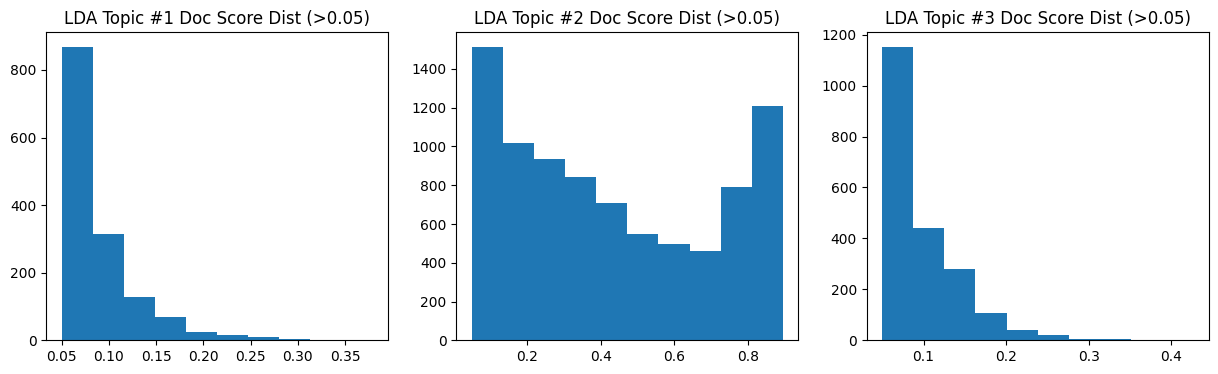

In [68]:
# LDA Topic documents for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_lda[:,i])
    plt.subplot(1,3,i+1)
    plt.hist(series[series > 0.05])
    plt.title('LDA Topic #{} Doc Score Dist (>0.05)'.format(i+1))
plt.show()

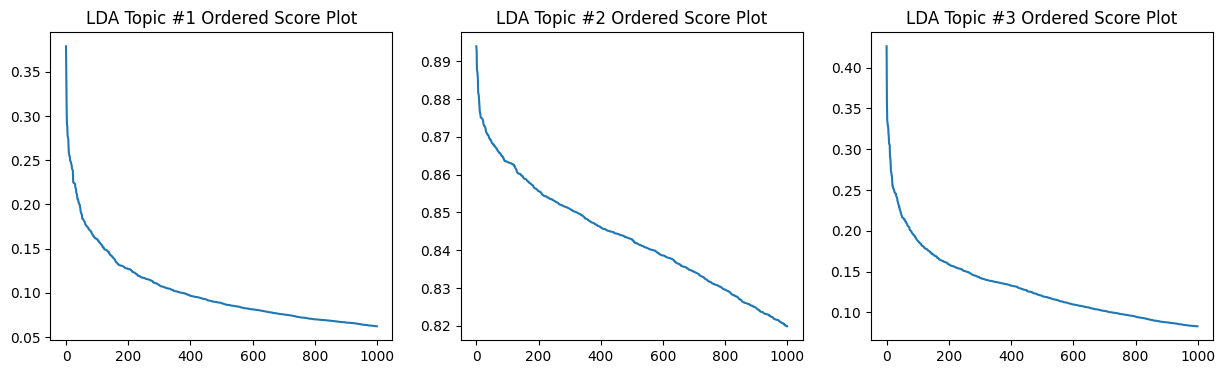

In [69]:
# LDA Topic document scores for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_lda[:,i]).copy().sort_values(ascending = False).reset_index(drop = True)
    plt.subplot(1,3,i+1)
    plt.plot(series[:1000])
    plt.title('LDA Topic #{} Ordered Score Plot'.format(i+1))
plt.show()

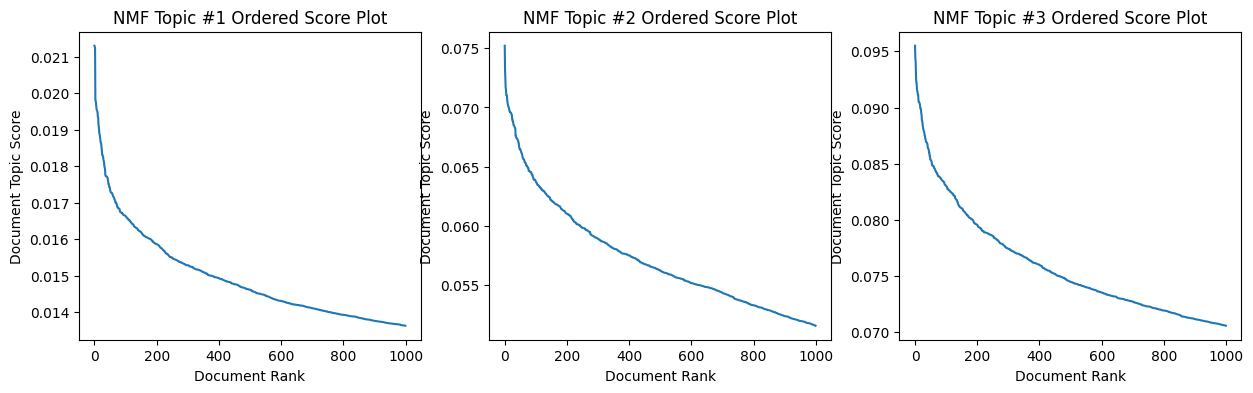

In [70]:
# NMF Topic document scores for topics 0-2
plt.figure(figsize=(15,4))
for i in range(3):
    series = pd.Series(text_nmf[:,i]).copy().sort_values(ascending = False).reset_index(drop = True)
    plt.subplot(1,3,i+1)
    plt.plot(series[:1000])
    plt.title('NMF Topic #{} Ordered Score Plot'.format(i+1))
    plt.xlabel('Document Rank')
    plt.ylabel('Document Topic Score')
#plt.savefig('DocsByTop_Score_Elbows.png', transparent = True)
plt.show()

In [81]:
recipes

,name,id,minutes,tags,nutrition,n_steps,steps,n_ingredients,ingredients,ingredient_text
0,arriba baked winter squash mexican style,137739,55,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",7,"[winter squash, mexican seasoning, mixed spice...",winter squash; mexican seasoning; mixed spice;...
1,a bit different breakfast pizza,31490,30,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",6,"[prepared pizza crust, sausage patty, eggs, mi...",prepared pizza crust; sausage patty; eggs; mil...
2,all in the kitchen chili,112140,130,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",13,"[ground beef, yellow onions, diced tomatoes, t...",ground beef; yellow onions; diced tomatoes; to...
3,alouette potatoes,59389,45,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,11,"[spreadable cheese with garlic and herbs, new ...",spreadable cheese with garlic and herbs; new p...
4,amish tomato ketchup for canning,44061,190,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,8,"[tomato juice, apple cider vinegar, sugar, sal...",tomato juice; apple cider vinegar; sugar; salt...
...,...,...,...,...,...,...,...,...,...,...
231570,zydeco soup,486161,60,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",22,"[celery, onion, green sweet pepper, garlic clo...",celery; onion; green sweet pepper; garlic clov...
231571,zydeco spice mix,493372,5,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],13,"[paprika, salt, garlic powder, onion powder, d...",paprika; salt; garlic powder; onion powder; dr...
231572,zydeco ya ya deviled eggs,308080,40,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...",8,"[hard-cooked eggs, mayonnaise, dijon mustard, ...",hard-cooked eggs; mayonnaise; dijon mustard; s...
231573,cookies by design cookies on a stick,298512,29,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,10,"[butter, eagle brand condensed milk, light bro...",butter; eagle brand condensed milk; light brow...


In [84]:
from functools import reduce
def qweight_array(query_length, qw_array = [1]):
    '''Returns descending weights for ranked query ingredients'''
    if query_length > 1:
        to_split = qw_array.pop()
        split = to_split/2
        qw_array.extend([split, split])
        return qweight_array(query_length - 1, qw_array)
    else:
        return np.array(qw_array)

def ranked_query(query):
    '''Called if query ingredients are ranked in order of importance.
    Weights and adds each ranked query ingredient vector.'''
    query = [[q] for q in query]      # place words in seperate documents
    q_vecs = [vectorizer.transform(q) for q in query] 
    qw_array = qweight_array(len(query),[1])
    q_weighted_vecs = q_vecs * qw_array
    q_final_vector = reduce(np.add,q_weighted_vecs)
    return q_final_vector

def overall_scores(query_vector):
    '''Calculates Query Similarity Scores against recipe title, instructions, and keywords.
    Then returns weighted averages of similarities for each recipe.'''
    final_scores = text_tfidf*query_vector.T*w_text
    return final_scores

def print_recipes(index, query, recipe_range):
    '''Prints recipes according to query similary ranks'''
    print('Search Query: {}\n'.format(query))
    for i, index in enumerate(index, recipe_range[0]):
        print('Recipe Rank: {}\t'.format(i+1),recipes.loc[index, 'name'],'\n')
        print('Ingredients:\n{}\n '.format(recipes.loc[index, 'ingredients']))
        print('Instructions:\n{}\n'.format(recipes.loc[index, 'steps']))
        
def Search_Recipes(query, query_ranked=False, recipe_range=(0,3)):
    '''Master Recipe Search Function'''
    if query_ranked == True:
        q_vector = ranked_query(query)
    else:
        q_vector = vectorizer.transform([' '.join(query)])
    recipe_scores = overall_scores(q_vector)
    sorted_index = pd.Series(recipe_scores.toarray().T[0]).sort_values(ascending = False)[recipe_range[0]:recipe_range[1]].index
    return print_recipes(sorted_index, query, recipe_range)
    

In [87]:
query = ['cheese', 'jalapeno', 'olives', 'sauce', 'banana']
Search_Recipes(query, query_ranked=True, recipe_range=(0,3))

Search Query: ['cheese', 'jalapeno', 'olives', 'sauce', 'banana']

Recipe Rank: 1	 jalapeno cheese crackers 

Ingredients:
['all-purpose flour', 'ground cumin', 'salt', 'ground red pepper', 'butter', 'jalapeno jack cheese', 'water', 'paprika']
 
Instructions:
['preheat oven to 400f', 'in a large mixing bowl stir together the flour , cumin , salt , and red pepper', 'cut in the butter until the size of coarse crumbs', 'stir in the shredded cheese', 'sprinkle the water over the mixture , stirring until all the dough is moistened', 'turn the dough onto a large piece of waxed paper or plastic wrap and gather the dough into a ball', 'then flatten into a disk', 'if necessary , wrap and refrigerate for 30 min or until easy to handle', 'on a lightly floured surface roll the dough to about 1 / 8-inch thickness', 'using a floured 2" cookie cutter to cut dough , rerolling as necessary', 'place pieces about 1 / 2 inch apart on an ungreased cookie sheet', 'bake for 8 min or until crackers are golden

C:\Users\mehta\AppData\Local\Temp\ipykernel_716\1786228918.py:43: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  sorted_index = pd.Series(recipe_scores.toarray().T[0]).sort_values(ascending = False)[recipe_range[0]:recipe_range[1]].index


In [90]:
# dumping the important variables for future prediction
import pickle

with open ('text_tfidf.pkl', 'wb') as f:
    pickle.dump(text_tfidf, f)

with open ('recipes.pkl', 'wb') as f:
    pickle.dump(recipes, f)

with open ('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)



In [93]:
vectorizer.__dict__

{'input': 'content',
 'encoding': 'utf-8',
 'decode_error': 'strict',
 'strip_accents': None,
 'preprocessor': None,
 'tokenizer': None,
 'analyzer': 'word',
 'lowercase': True,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'stop_words': None,
 'max_df': 1.0,
 'min_df': 1,
 'max_features': None,
 'ngram_range': (1, 1),
 'vocabulary': None,
 'binary': False,
 'dtype': numpy.float64,
 'norm': 'l2',
 'use_idf': True,
 'smooth_idf': True,
 'sublinear_tf': False,
 '_tfidf': TfidfTransformer(),
 'fixed_vocabulary_': False,
 '_stop_words_id': 140717157674184,
 'stop_words_': set(),
 'vocabulary_': {'arriba': 2550,
  'baked': 3486,
  'winter': 61176,
  'squash': 52250,
  'mexican': 33578,
  'style': 53330,
  'season': 48358,
  'mix': 34418,
  'spice': 51731,
  'honey': 24826,
  'butter': 7351,
  'olive': 37670,
  'oil': 37491,
  'salt': 47210,
  'choice': 10207,
  'proceed': 43220,
  'recipe': 44707,
  'depend': 14723,
  'size': 50177,
  'cut': 13887,
  'half': 23425,
  'fourth': 20168,
  'remove': 